### Example Use of Broadcast Variables in Spark

This Notebook shows an implementation of [HITS Algorithm](https://en.wikipedia.org/wiki/HITS_algorithm) in PySpark as an experiment for use of broadcast variables.

Sample was generated to illustrate the use of broadcast variables in PySpark in local environment, but it is also possible to run this code on Wikipedia dataset.

In [14]:
import networkx as nx
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 1. Generate and Visualize a Simple Example with NetworkX

Bolded line tips are NetworkX arrows, which show direction of the connection.

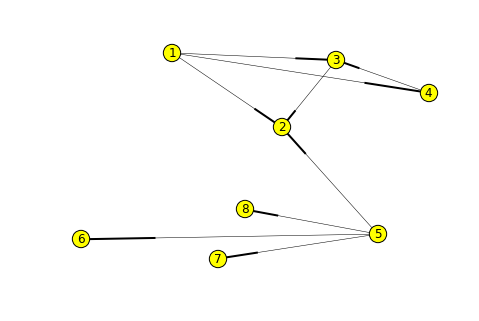

In [15]:
G = nx.DiGraph()
G.add_edges_from([(1, 2), (1, 3), (1, 4), (4, 3), (3, 2), (5, 2), (5, 6), (5, 7), (5, 8)])
nx.draw(G, with_labels = True, width=0.5, node_color='yellow')

### 2. Initialize Two RDDs with Sample Data from Above

In [16]:
outlinks_rdd = sc.parallelize([[1, [2, 3, 4]], [4, [3]], [3, [2]], [5, [6, 7, 8, 2]]])
print outlinks_rdd.collect()

inlinks_rdd = sc.parallelize([[4, [1]], [3, [1, 4]], [2, [1, 3, 5]], [6, [5]], [7, [5]], [8, [5]]])
print inlinks_rdd.collect()

[[1, [2, 3, 4]], [4, [3]], [3, [2]], [5, [6, 7, 8, 2]]]
[[4, [1]], [3, [1, 4]], [2, [1, 3, 5]], [6, [5]], [7, [5]], [8, [5]]]


### 3. Initialize a Broadcast Variables for Hub and Auth Scores

In [17]:
hub_score = sc.broadcast({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})
print hub_score.value

auth_score = sc.broadcast({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})
print auth_score.value

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}


### 4. Define Python UDFs

These two functions modify Auth and Hub RDDs with their respective Auth and Hub scores.

We use dictionary in the broadcast variable as a lookup and modify an existing RDDs with new scores.

In [18]:
def get_auth(x):
    page = x[0]
    outlinks = x[1]
    new_auth_score = 0
    
    # Get values from broadcast variable
    hub_lookup = hub_score.value
    
    for i in outlinks:
        try:
            new_auth_score += hub_lookup[i]
        except KeyError:
            pass
    
    return (page, outlinks, new_auth_score)

def get_hub(x):
    page = x[0]
    inlinks = x[1]
    new_hub_score = 0
    
    # Get values from broadcast variable
    auth_lookup = auth_score.value
      
    for i in inlinks:
        try:
            new_hub_score += auth_lookup[i]
        except KeyError:
            pass
    
    return (page, inlinks, new_hub_score)

### 5. Collect Auth and Hub Scores from an RDD and Normalize the Scores

This step is repeated multiple times untill scores converge.

In [19]:
outlinks_rdd = outlinks_rdd.map(lambda x: get_auth(x))

temp_auth_dict = auth_score.value
auth_score_collect = outlinks_rdd.map(lambda x: [x[0], x[2]]).collect()

for i in auth_score_collect:
    try:
        temp_auth_dict[i[0]] = i[1]
    except KeyError:
        pass

# Normalize
# Get values from broadcast variable (dictionary)
auth_get = auth_score.value.values()
norm = np.sqrt(sum([i ** 2 for i in auth_get]))

for k, v in temp_auth_dict.iteritems():
    temp_auth_dict[k] = round(v / norm, 2)
    
# Update the broadcast variable
# Unpersist from workers
auth_score.unpersist()

# Delete local Python object
del auth_score

auth_score = sc.broadcast(temp_auth_dict)
print auth_score.value

{1: 0.54, 2: 0.18, 3: 0.18, 4: 0.18, 5: 0.72, 6: 0.18, 7: 0.18, 8: 0.18}


In [20]:
inlinks_rdd = inlinks_rdd.map(lambda x: get_hub(x))

temp_hub_dict = hub_score.value
hub_score_collect = inlinks_rdd.map(lambda x: [x[0], x[2]]).collect()

for i in hub_score_collect:
    try:
        temp_hub_dict[i[0]] = i[1]
    except KeyError:
        pass

# Normalize    
# Get values from broadcast variable (dictionary)
hub_get = hub_score.value.values()
norm = np.sqrt(sum([i ** 2 for i in hub_get]))

for k, v in temp_auth_dict.iteritems():
    temp_hub_dict[k] = round(v / norm, 2)
       
# Update broadcast variable
# Unpersist from workers
hub_score.unpersist()

# Delete local Python object
del hub_score

hub_score = sc.broadcast(temp_hub_dict)
print hub_score.value

{1: 0.21, 2: 0.07, 3: 0.07, 4: 0.07, 5: 0.28, 6: 0.07, 7: 0.07, 8: 0.07}


### 6. Unpersist and Delete Local Objects

In [21]:
auth_score.unpersist()
del auth_score
hub_score.unpersist()
del hub_score